In [1]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.1                         
year           2019                        
month          07                          
day            05                          
svn rev        76782                       
language       R                           
version.string R version 3.6.1 (2019-07-05)
nickname       Action of the Toes          

In [36]:

dim(tmp)
dim(annot)

[1] 47 16

[1] 47  3

In [41]:
setwd('/media/ben/9c17f1c9-a45e-49ec-b547-8fbd2f25ccc6/GlyCompare/')

#### load libraries
source('example_notebook/functions.r')


clean<-function(x,skip=1,annot){
    x=cbind(annot,x)
    x$Secretor = ! x$Pateint.ID %in% c('L2','L3')
    x$scretor_col = ifelse(x$Secretor,'black','grey')
    x$DPP_col = heat.colors(length(unique(x$DPP)))[factor(x$DPP)]
    x$subject_col = rainbow(length(levels(x$Pateint.ID)))[x$Pateint.ID]
    x
}

##### load & prep data
annot = na.omit(read.csv('example_data/paper_hmo/source_data/annotation.csv'))
#head(annot)

tmp=t(data.matrix(read.csv('example_data/paper_hmo/intermediate_file/paper_hmo_motif_abd_table.csv',row.names=1,header =TRUE)))
colnames(tmp) = paste0('X',colnames(tmp))
rownames(tmp) = NULL
smandm = clean( tmp,annot=annot)

tmp<-read.csv('example_data/paper_hmo/source_data/abundance_table.csv')[-41,-1]
tmp$SUM=rowSums(tmp)
gly = clean ( tmp,annot=annot )

head(smandm)
head(gly)

vars = gsub('\\.','',c( grep('X',colnames(smandm),value=T), colnames(gly)[4:19] ))

gly_p = gly
gly_p[,colnames(gly)[4:19]] = gly[,colnames(gly)[4:19]]/as.numeric(as.character(gly$SUM))

data=list(#motif_abundance=ma,motif_abundance_dropped=mand,#motif_abundance_dropped_more=mandm,
    smallest_motif_abundance_dropped_more=smandm,glycan_concentration=gly,glycan_percent=gly_p)

data = lapply(data,function(x){
    colnames(x) = gsub('\\.','',colnames(x))
    x
})

keep_data=c('smallest_motif_abundance_dropped_more','glycan_percent')#,'glycan_percent')

#######################


Dataset,Pateint.ID,DPP,X1,X4,X5,X8,X13,X15,X18,⋯,X113,X120,X127,X141,X142,X143,Secretor,scretor_col,DPP_col,subject_col
<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<chr>
1,L1,1,0.19166973,0.7856543,1,0.06204399,0.6677340,0.15944045,0.2499081,⋯,0.05178206,0.002598289,0.013227652,0.0013385124,0.005012860,0.0082147919,TRUE,black,#FF0000FF,#FF0000FF
1,L1,2,0.11718214,0.8259251,1,0.06456775,0.7357523,0.08697214,0.3489010,⋯,0.04275123,0.001698292,0.007511676,0.0048662595,0.007250400,0.0002612757,TRUE,black,#FF3300FF,#FF0000FF
1,L1,3,0.07822616,0.7939394,1,0.07757576,0.7167775,0.03228381,0.5018477,⋯,0.04795270,0.002690318,0.006001478,0.0007982262,0.004050259,0.0019512195,TRUE,black,#FF6600FF,#FF0000FF
1,L1,4,0.09139850,0.7912533,1,0.09345512,0.7062061,0.03405517,0.5156666,⋯,0.05676869,0.004445923,0.010555287,0.0011492862,0.006986451,0.0035688362,TRUE,black,#FF9900FF,#FF0000FF
1,L1,7,0.06754382,0.7672239,1,0.07069797,0.6536746,0.04064345,0.5264723,⋯,0.07141892,0.009958095,0.014689316,0.0036047402,0.012165998,0.0025233182,TRUE,black,#FFCC00FF,#FF0000FF
1,L1,14,0.08962425,0.7456007,1,0.10180919,0.6507500,0.03593629,0.5584970,⋯,0.05628576,0.006680068,0.013885882,0.0019174269,0.010731406,0.0031544766,TRUE,black,#FFFF00FF,#FF0000FF


Dataset,Pateint.ID,DPP,X2.FL,X3FL,LNnT,X3.SL,LNT,LNFP.I,LNFP.II,⋯,DSLNT,FLNH,DFLNH,FDSLNH,DSLNH,SUM,Secretor,scretor_col,DPP_col,subject_col
<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<dbl>,<lgl>,<chr>,<chr>,<chr>
1,L1,1,21765,1034,295,5781,882,3578,435,⋯,243,99,191,313,51,38102,TRUE,black,#FF0000FF,#FF0000FF
1,L1,2,17207,394,327,2335,1423,5269,431,⋯,179,52,222,8,149,30619,TRUE,black,#FF3300FF,#FF0000FF
1,L1,3,15841,135,748,874,3642,8313,506,⋯,191,91,137,66,27,33825,TRUE,black,#FF6600FF,#FF0000FF
1,L1,4,15213,65,735,736,3263,7990,444,⋯,352,147,231,118,38,33064,TRUE,black,#FF9900FF,#FF0000FF
1,L1,7,9739,41,381,729,3342,4547,504,⋯,93,221,270,56,80,22193,TRUE,black,#FFCC00FF,#FF0000FF
1,L1,14,13347,7,843,922,4587,7479,565,⋯,178,216,347,102,62,32335,TRUE,black,#FFFF00FF,#FF0000FF


### examine glycan and motif level clustering (Supp Fig6)

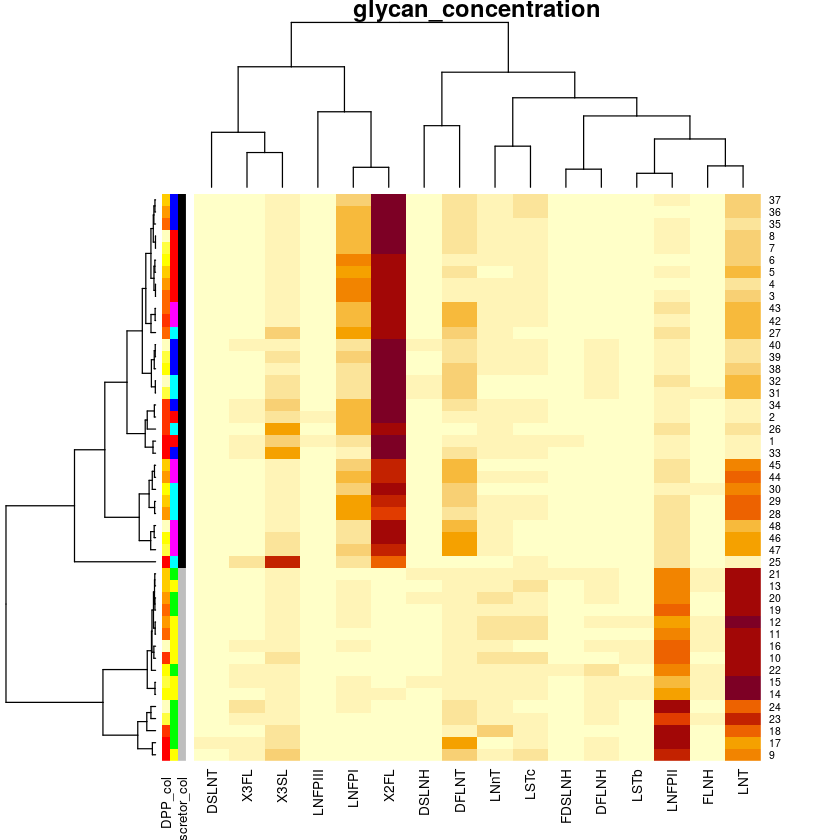

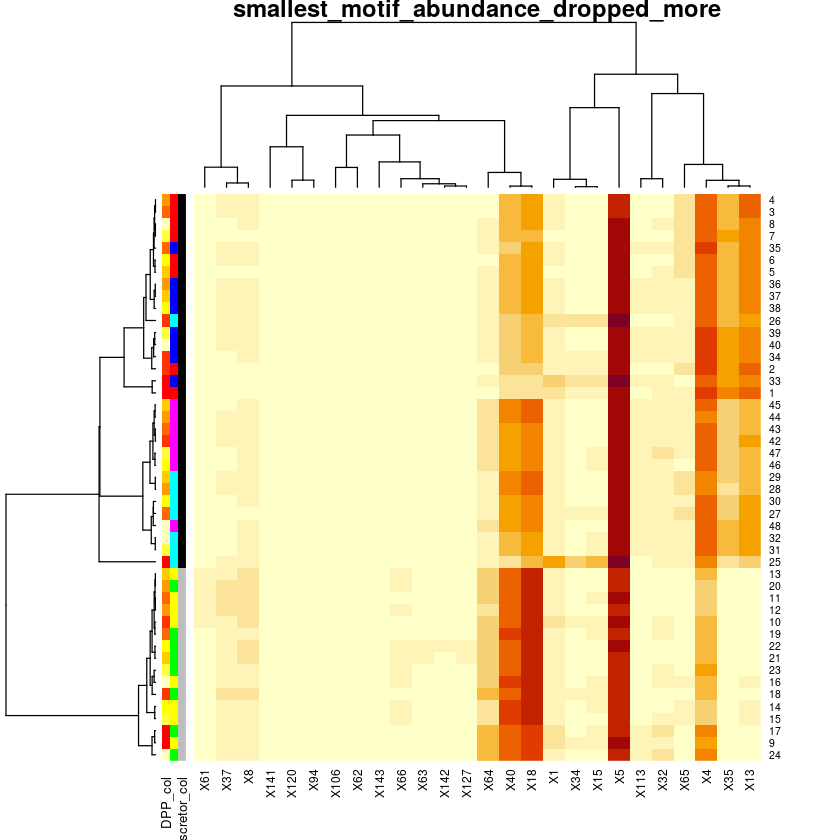

In [45]:
#pdf('~/Desktop/hmoclusters.pdf',height=10,width=10)
## glycan abundance
x=data$glycan_percent
data_i = data.matrix(x[,colnames(x)%in%vars])
cols = as.matrix(x[,rev(c('scretor_col','subject_col','DPP_col'))])
heatmap.plus( data_i,RowSideColors=cols,main='glycan_concentration', 
    hclustfun=function(x) hclust(x,method="complete"),distfun=function(x) as.dist((1 - cor(  t(x) ,method='pearson' ))/2))

## motif abundance        
x=data$smallest_motif_abundance_dropped_more
data_i = data.matrix(x[,colnames(x)%in%vars])
cols = as.matrix(x[,rev(c('scretor_col','subject_col','DPP_col'))])
heatmap.plus( data_i,RowSideColors=cols,main='smallest_motif_abundance_dropped_more', 
    hclustfun=function(x) hclust(x,method="complete"),distfun=function(x) as.dist((1 - cor(  t(x) ,method='pearson' ))/2))
#dev.off()

# Phenotype-Glycan & Phenotype-Motif Abundance Associations


## Predictability of every glycan and motif from Secretor status and DPP (Supp Fig8, Fig4b)
This analysis discovered several motifs signifiantly associated with secretor status and DPP, including X80

In [559]:
library(gee)

add_models=list()
inter_models=list()

i=0
out_i=lapply( data, function(x){
    i=i+1
    x$Secretor = as.numeric(x$Secretor)
    #	x$Secretor = relevel(factor(ifelse(x$Secretor,'secretor','nonsecretor')),ref='nonsecretor')
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        #try(mod<-gee(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
        try(mod<-gee(as.formula(paste('scale(log(',motif,'+.001))~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        #try(mod<-gee(as.formula(paste('Secretor~scale(',motif,')+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
    mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
    colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
    mods$type = 'additive'
    mods$robustPr = 2*pnorm(-abs(mods$robustZ))
    mods1=mods[mods$response%in%vars & mods$vars!='Intercept',]
    
    mods1
})
out=do.call(rbind,out_i) #[-(4:5)])
out$data = unlist(lapply(strsplit(rownames(out),'\\.'),function(x) x[1]))


#############
out$response = factor( as.character(out$response), levels = sample(unique(as.character(out$response))))

library(geepack) 
              
# get whole models
out_models=lapply( data, function(x){
    i=i+1
    x$Secretor = as.numeric(x$Secretor)
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        try(mod<-geeglm(as.formula(paste('scale(log(',motif,'+.0001))~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
#        try(mod<-geeglm(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
#        try(mod<-geeglm(as.formula(paste('Secretor~log(DPP)+scale(',motif,')')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NA)}else{mod}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    mods_i
})

Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.937      -1.830       0.143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -1.2288      1.6952      0.0585 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.788      -1.708       0.179 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      1.146      -0.305      -0.499 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -0.3417      0.2826      0.0817 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.475       0.256      -0.340 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.9612     -1.3909     -0.0231 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -1.4423      2.0422      0.0503 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.825      -1.692       0.154 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.442       0.344      -0.353 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.624      -1.313       0.128 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      1.323      -0.595      -0.492 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -0.5759      0.6911      0.0634 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -1.3905      2.0598      0.0169 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.671      -1.629       0.213 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      1.225      -1.085      -0.269 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.859      -1.651       0.121 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.7648     -1.2174      0.0201 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      1.293      -0.510      -0.505 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.184      -1.253       0.339 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.724      -1.390       0.102 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -1.2859      1.7964      0.0534 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.815       0.736       0.174 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.0297     -0.4065      0.1259 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.320      -0.942       0.497 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.553      -1.283       0.155 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.0749     -1.2852      0.4081 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.374      -1.369       0.280 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.746      -0.268       0.488 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.760      -0.710      -0.154 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -1.1319      1.9003     -0.0642 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.577      -0.244      -0.220 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.172       0.757      -0.354 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.112       1.213      -0.482 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.2645     -0.4400      0.0136 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.961       1.935      -0.166 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      1.194      -1.262      -0.191 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.215       1.091      -0.267 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      1.260      -1.001      -0.317 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.589       0.755      -0.574 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.673       1.386      -0.127 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.356       0.977      -0.528 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.173      -0.290       0.192 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.1415      0.0588     -0.0952 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.383       0.362      -0.328 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.926       0.688       0.249 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -1.3905      2.0598      0.0169 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.937      -0.935      -0.169 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.5386     -0.7320     -0.0295 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.442       0.344      -0.353 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.415      -1.498       0.303 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  -1.283766    1.944573    0.000621 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     1.0743     -1.8301      0.0701 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.208       0.479      -0.277 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     1.2086     -1.8433      0.0038 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      1.199      -0.368      -0.505 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.815       0.736       0.174 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.813       0.130      -0.475 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.0748     -1.2852      0.4081 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.374      -1.369       0.280 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.760      -0.710      -0.154 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.746      -0.268       0.488 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na

In [308]:
# x=data$glycan_concentration

# p=unlist(apply( x[colnames(x)[colnames(x)%in%vars]],2,function(y){
#     out=NULL;
#     try(out<-shapiro.test(scale(log(y+.001)))$p.value);
#     out} ))
# hist(p)

In [570]:
xtabs=lapply(out_models$smallest_motif_abundance_dropped_more,parseSummary.GEEpack,odsig=3)
#print(xtabs$X80)
print('x80')
print(xtabs$X80)

xtabs2=lapply(out_models$glycan_percent,parseSummary.GEEpack,odsig=3)
#print(xtabs$X80)
print('lnt')
print(xtabs2$LNT)
print('lstb')
print(xtabs2$LSTb)
print('dslnt')
print(xtabs2$DSLNT)

#### to see all motif and glycan models, uncomment the next line of code
#xtabs   # motifs
#xtabs2 #glycans

[1] "x80"
[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sat Jul 20 19:36:33 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 0.74 & (0.348 - 1.13) & 0.01 \\ 
  Secretor & -1.37 & (-0.642 - -2.09) & 0.00 \\ 
  log(DPP) & 0.09 & (0.0654 - 0.117) & 0.53 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sat Jul 20 19:36:33 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 0.45 \\ 
  4 & Degrees of Freedom & 44.00 \\ 
  5 & Shapiro-Wilks P & 0.53 \\ 
   \hline
\end{tabular}
\end{table}

[1] "lnt"
[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sat Jul 20 19:36:33 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 0.42 & (

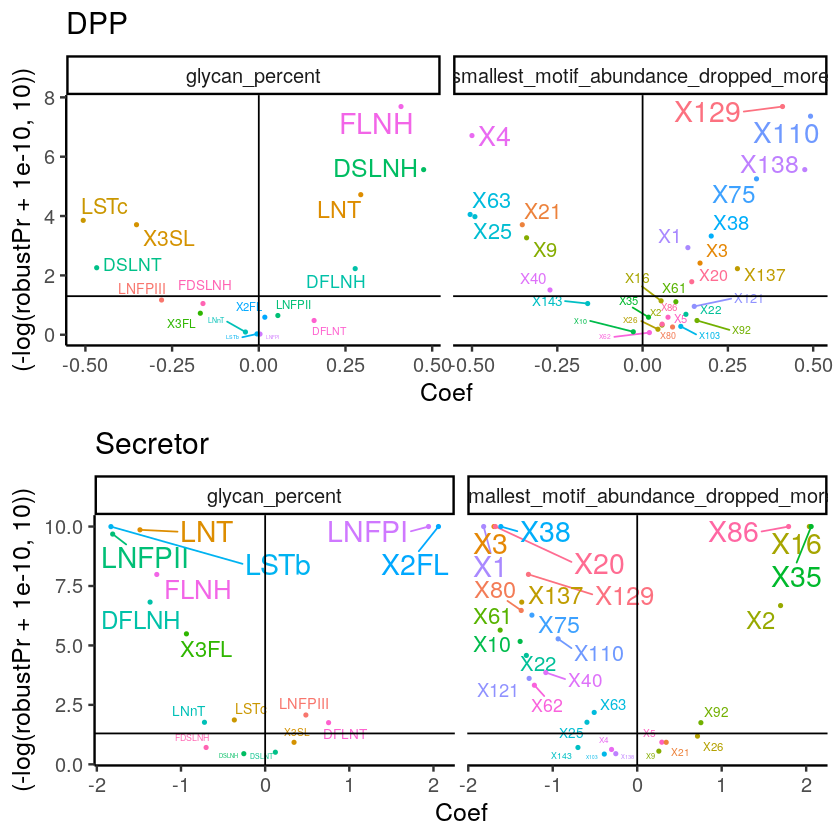

In [542]:

#ggplot( data=droplevels(out[out$type=='additive' & out$data%in%keep_data,]) ,
g1<-ggplot( data=droplevels(out[out$type=='additive'& out$data%in%keep_data &out$vars=='DPP',]), # & !grepl('DPP',rownames(out)),]) ,
       aes(x=Coef,y=(-log(robustPr+1e-10,10)),size=(-log(robustPr+1e-10,10)),
        label=response,color=response,group=response))+
    geom_text_repel() + #scale_x_continuous(trans='log2') +
    facet_grid(~data,scale='free')+geom_point(size=.8)+#geom_path(size=.3)+
    geom_hline(yintercept=1.3)+geom_vline(xintercept=0)+ guides(color=FALSE,size=FALSE)+
    theme_classic(base_size=15)+ggtitle('DPP')

g2<-ggplot( data=droplevels(out[out$type=='additive'& out$data%in%keep_data &out$vars=='Secretor',]), # & !grepl('DPP',rownames(out)),]) ,
       aes(x=Coef,y=(-log(robustPr+1e-10,10)),size=(-log(robustPr+1e-10,10)),
        label=response,color=response,group=response))+
    geom_text_repel() + #scale_x_continuous(trans='log2') +
    facet_grid(~data,scale='free')+geom_point(size=.8)+#geom_path(size=.3)+
    geom_hline(yintercept=1.3)+geom_vline(xintercept=0)+ guides(color=FALSE,size=FALSE)+
    theme_classic(base_size=15)+ggtitle('Secretor')

g = grid.arrange(grobs=list(g1,g2),nrow=2)

#ggsave(g,filename = '~/Desktop/suppfig8.pdf',height=15,width=15)



## Demonstration that X80 behaves distinctly from its related glycans (Fig4b)

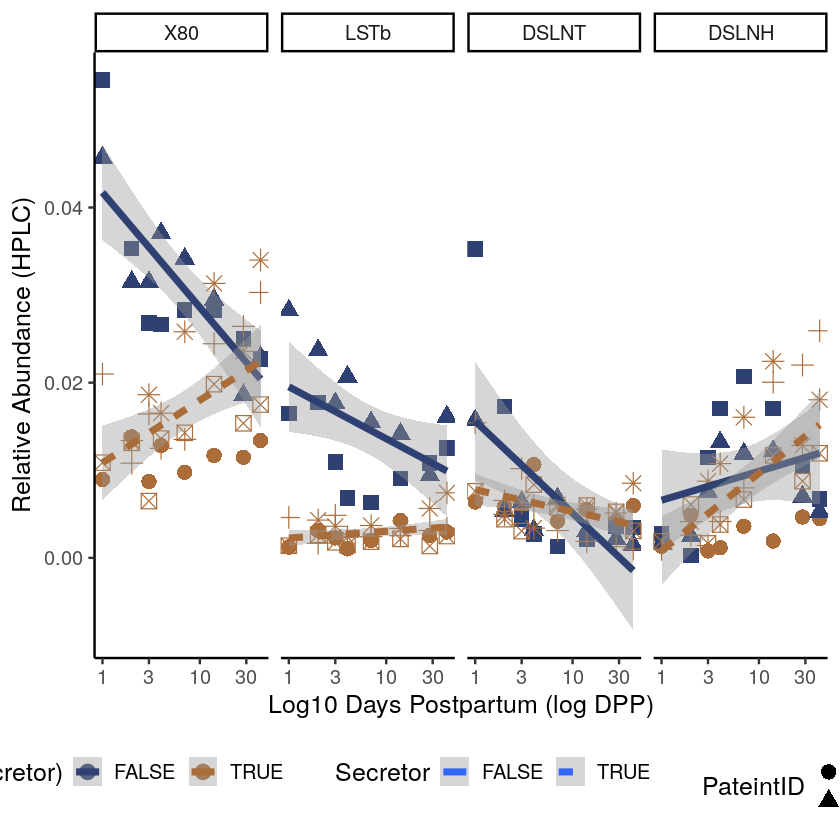

In [545]:
tmp= melt(cbind( data$smallest_motif_abundance_dropped_more[,c('DPP','X80','Secretor','PateintID')],data$glycan_percent[,c('DSLNT','DSLNH','LSTb')]) , id.vars=c('DPP','Secretor','PateintID'))

tmp$variable = factor(tmp$variable,levels=c('X80','LSTb','DSLNT','DSLNH'))
g<-ggplot(data=droplevels(tmp),aes(x=DPP,y=value,linetype=Secretor,color=factor(Secretor)))+
		geom_point(aes(shape=PateintID),size=4)+scale_x_log10()+
		xlab('Log10 Days Postpartum (log DPP)')+ylab('Relative Abundance (HPLC)')+
		stat_smooth(method='lm',size=2,se=T)+facet_grid(cols=vars(variable))+ 
        theme_classic(base_size = 15)+theme(legend.position="bottom")+
        scale_color_manual(values=c("#2E4172", "#AA6C39"))+guides(linetype=F)
g
#ggsave(g,filename = '~/Desktop/fig4b.pdf',height=10,width=15)

## Using the Product-Reactant ratio association to phenotype to determine important reactions in biosynthesis (Fig5 supporting exploration)

In [549]:
#### load heirachy
r = read.csv('example_data/hmo_stats_data/edges.txt',header=FALSE)
heir = graph_from_edgelist( cbind( as.character(r[,1]) , as.character(r[,2]) ))
#plot(heir, layout=layout_as_tree(heir))

#### data
tmp = data$smallest_motif_abundance_dropped_more

comp=list()
comp_clean=list()
p = c(); lfc=c()
for( e in E(heir)){
    p = c(p,1);
    lfc=c(lfc,0);

    print(ends(heir,e))
    en=as.character(ends(heir,e))
    if(any(! paste0('X',en) %in% colnames(tmp) )){print(paste('skip',paste(en,collapse='_')));next}
    if( !all( apply(tmp[,paste0('X',en)],2,sd) > 1e-4 ) | all( tmp[[paste0('X',en[1])]] == tmp[[paste0('X',en[2])]] ) ){
        print(paste('skip',paste(en,collapse='_')));next}
    # run models
    f1 = Secretor ~ log(DPP)
    f2 = as.formula(paste0('Secretor ~ log(DPP) + I(',paste(paste0('X',rev(en)),collapse='/'),')'  ) )

    m1 = geeglm( f1, id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    m2 = geeglm( f2 , id=PateintID,data=tmp,corstr='exchangeable',family='binomial')

    f0 = as.formula(paste0('Secretor ~ scale(X',en[1],')'))
    f = as.formula(paste0('Secretor ~  scale(X',en[1],') + scale(X',en[2],')'  ) )

    m0 = geeglm( f0, id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    m = geeglm( f , id=PateintID,data=tmp,corstr='exchangeable',family='binomial')

    aov = anova(m0,m,test='LRT')

    out = data.frame( coef(summary(m2)) )
    out$iter = paste(en,collapse='_')
    out$vars = rownames(out)
    out$LRT = aov[[3]]

    #if(any(abs(out$Estimate)>15)){next}

    p[length(p)] = aov[[3]]
    lfc[length(lfc)] = coef(summary(m2))[3,1]

    comp[[paste(en,collapse='_')]] = list(m1,m2,aov,m)
    comp_clean[[paste(en,collapse='_')]] = out
}

out=do.call(rbind,comp_clean)
out = out[!grepl('Intercept|DPP',rownames(out)),]
#write.csv(out,file='motifAnyl/motif_heir.12.7.18.Bokan/stats.csv')


     [,1] [,2]
[1,] "5"  "20"
[1] "skip 5_20"
     [,1] [,2]
[1,] "5"  "21"
[1] "skip 5_21"
     [,1] [,2]
[1,] "5"  "26"
[1] "skip 5_26"
     [,1] [,2]
[1,] "5"  "29"
[1] "skip 5_29"
     [,1] [,2]
[1,] "5"  "35"
[1] "skip 5_35"
     [,1] [,2]
[1,] "20" "37"
[1] "skip 20_37"
     [,1] [,2]
[1,] "20" "38"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "40"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "41"
[1] "skip 20_41"
     [,1] [,2]
[1,] "20" "43"
[1] "skip 20_43"
     [,1] [,2]
[1,] "20" "51"
[1] "skip 20_51"
     [,1] [,2]
[1,] "20" "53"
[1] "skip 20_53"
     [,1] [,2]
[1,] "26" "43"
[1] "skip 26_43"
     [,1] [,2]
[1,] "29" "45"
[1] "skip 29_45"
     [,1] [,2]
[1,] "29" "46"
[1] "skip 29_46"
     [,1] [,2]
[1,] "29" "51"
[1] "skip 29_51"
     [,1] [,2]
[1,] "37" "61"
[1] "skip 37_61"
     [,1] [,2]
[1,] "37" "64"
[1] "skip 37_64"
     [,1] [,2]
[1,] "38" "61"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "65"
[1] "skip 38_65"
     [,1] [,2]
[1,] "38" "79"
[1] "skip 38_79"
     [,1] [,2]
[1,] "38" "80"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "85"
[1] "skip 38_85"
     [,1] [,2]
[1,] "38" "86"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "40" "62"
     [,1] [,2]
[1,] "40" "63"
     [,1] [,2]
[1,] "40" "73"
[1] "skip 40_73"
     [,1] [,2]
[1,] "41" "62"
[1] "skip 41_62"
     [,1] [,2]
[1,] "41" "74"
[1] "skip 41_74"
     [,1] [,2]
[1,] "43" "64"
[1] "skip 43_64"
     [,1] [,2]
[1,] "43" "65"
[1] "skip 43_65"
     [,1] [,2]
[1,] "45" "66"
[1] "skip 45_66"
     [,1] [,2]
[1,] "45" "75"
[1] "skip 45_75"
     [,1] [,2]
[1,] "45" "88"
[1] "skip 45_88"
     [,1] [,2]
[1,] "46" "66"
[1] "skip 46_66"
     [,1] [,2]
[1,] "46" "76"
[1] "skip 46_76"
     [,1] [,2]
[1,] "51" "73"
[1] "skip 51_73"
     [,1] [,2]
[1,] "51" "74"
[1] "skip 51_74"
     [,1] [,2]
[1,] "51" "75"
[1] "skip 51_75"
     [,1] [,2]
[1,] "51" "76"
[1] "skip 51_76"
     [,1] [,2]
[1,] "51" "81"
[1] "skip 51_81"
     [,1] [,2]
[1,] "51" "85"
[1] "skip 51_85"
     [,1] [,2]
[1,] "53" "80"
[1] "skip 53_80"
     [,1] [,2]
[1,] "53" "81"
[1] "skip 53_81"
     [,1] [,2]
[1,] "61" "92"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "62" "97"
[1] "skip 62_97"
     [,1] [,2] 
[1,] "62" "113"
[1] "skip 62_113"
     [,1] [,2] 
[1,] "63" "113"
[1] "skip 63_113"
     [,1] [,2] 
[1,] "63" "116"
[1] "skip 63_116"
     [,1] [,2]
[1,] "64" "92"
[1] "skip 64_92"
     [,1] [,2]
[1,] "65" "92"
[1] "skip 65_92"
     [,1] [,2] 
[1,] "66" "102"
[1] "skip 66_102"
     [,1] [,2]
[1,] "73" "97"
[1] "skip 73_97"
     [,1] [,2]
[1,] "73" "98"
[1] "skip 73_98"
     [,1] [,2] 
[1,] "73" "100"
[1] "skip 73_100"
     [,1] [,2] 
[1,] "73" "116"
[1] "skip 73_116"
     [,1] [,2]
[1,] "74" "97"
[1] "skip 74_97"
     [,1] [,2]
[1,] "74" "99"
[1] "skip 74_99"
     [,1] [,2] 
[1,] "74" "101"
[1] "skip 74_101"
     [,1] [,2]
[1,] "75" "98"
[1] "skip 75_98"
     [,1] [,2]
[1,] "75" "99"
[1] "skip 75_99"
     [,1] [,2] 
[1,] "75" "102"
[1] "skip 75_102"
     [,1] [,2] 
[1,] "75" "104"
[1] "skip 75_104"
     [,1] [,2] 
[1,] "75" "110"
     [,1] [,2] 
[1,] "75" "117"
[1] "skip 75_117"
     [,1] [,2] 
[1,] "76" "100"
[1] "skip 76_

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "80" "109"
[1] "skip 80_109"
     [,1] [,2] 
[1,] "81" "104"
[1] "skip 81_104"
     [,1] [,2] 
[1,] "81" "109"
[1] "skip 81_109"
     [,1] [,2] 
[1,] "85" "108"
[1] "skip 85_108"
     [,1] [,2] 
[1,] "85" "109"
[1] "skip 85_109"
     [,1] [,2] 
[1,] "85" "110"
[1] "skip 85_110"
     [,1] [,2] 
[1,] "85" "112"
[1] "skip 85_112"
     [,1] [,2] 
[1,] "86" "112"
[1] "skip 86_112"
     [,1] [,2] 
[1,] "88" "117"
[1] "skip 88_117"
     [,1] [,2] 
[1,] "97" "121"
[1] "skip 97_121"
     [,1] [,2] 
[1,] "97" "122"
[1] "skip 97_122"
     [,1] [,2] 
[1,] "97" "130"
[1] "skip 97_130"
     [,1] [,2] 
[1,] "98" "121"
[1] "skip 98_121"
     [,1] [,2] 
[1,] "98" "123"
[1] "skip 98_123"
     [,1] [,2] 
[1,] "98" "135"
[1] "skip 98_135"
     [,1] [,2] 
[1,] "98" "136"
[1] "skip 98_136"
     [,1] [,2] 
[1,] "99" "121"
[1] "skip 99_121"
     [,1] [,2] 
[1,] "99" "124"
[1] "skip 99_124"
     [,1] [,2] 
[1,] "99" "131"
[1] "skip 99_131"
     [,1]  [,2] 
[1,] "100" "122"
[1] "skip 100_12

In [550]:
out$q = p.adjust(out$LRT,'fdr')
#hist(out$q,main='FDR corrected significance of Likelihood Ratio Test\n(significantly secretion-associated reactions)')
sub<-out[out$q>0&out$q<.1,]
sub[order(sub$q),]
# E(heir)$p = p
# E(heir)$lfc = lfc
# E(heir)$q = p.adjust(p,'fdr')

# E(heir)$weight = (-log(E(heir)$q+.01,10)*10+.5)
# V(heir)$weight = strength(heir,mode='out')


# #pdf('motifAnyl/motif_heir.12.7.18.Bokan/significance_network.pdf',height=10,width=10)
# plot(heir,layout=layout_as_tree(heir),
#     edge.width=E(heir)$weight,edge.arrow.size=0,#edge.color=E(heir)$color,
#     vertex.size=5,vertex.label.cex=1,vertex.label.family='sans',
#     vertex.color=NA,vertex.frame.color=NA,main=)

print(parseSummary.GEEpack(comp$'38_80'[[2]],logit=TRUE))
print(parseSummary.GEEpack(comp$'80_103'[[2]],logit=TRUE))

,Estimate,Std.err,Wald,Pr...W..,iter,vars,LRT,q
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
110_129.I(X129/X110),0.0178,0.0103,3.00,0.0831,110_129,I(X129/X110),0.0248,0.0271
80_103.I(X103/X80),-0.0526,0.0223,5.56,0.0183,80_103,I(X103/X80),0.0487,0.0487


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sat Jul 20 19:27:23 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 2.00 & (-1.4 - 5.4) & 0.42 \\ 
  log(DPP) & 1.00 & (1 - 1) & 0.14 \\ 
  I(X80/X38) & 0.99 & (0.957 - 1.02) & 0.55 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sat Jul 20 19:27:23 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & -0.00 \\ 
  4 & Degrees of Freedom & 44.00 \\ 
  5 & Shapiro-Wilks P &  \\ 
   \hline
\end{tabular}
\end{table}

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sat Jul 20 19:27:23 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 2.07 & (-1.49 - 5.63) & 0.41 \\ 
  log(DPP)

## Exploration of specific reactions highlighted by anylizing the association of Product-Reactant ratio to Secretor status (Fig5)

In [551]:

# #g = grid.arrange(grobs=list(
#     ggplot(data[[1]],aes(x=DPP,y=X80/X38,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(PateintID)))+
#         geom_point(size=4,show.legend=F)+stat_smooth(method='lm',size=2,se=F,show.legend=F)+
#         theme_classic(base_size=20)+scale_x_log10()+ylab('Relative Motif Abundance Ratio')+
#         ggtitle("Percent of LNT converted to LSTb\n(X80/X38)")+xlab("Log10 Days Postpartum (log DPP)")+
#         scale_color_manual(values=c("#2E4172", "#AA6C39"))#,
#     ggplot(data[[1]],aes(x=DPP,y=X103/X80,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(PateintID)))+
#         geom_point(size=4,show.legend=F)+stat_smooth(method='lm',size=2,se=F,show.legend=F)+
#         theme_classic(base_size=20)+scale_x_log10()+ylab('Relative Motif Abundance Ratio')+
#         ggtitle("Percent of LSTb converted to DSLNT\n(X103/X80)")+xlab("Log10 Days Postpartum (log DPP)")+
#         scale_color_manual(values=c("#2E4172", "#AA6C39"))
# #),nrow=2)
# #ggsave(g,filename='motifAnyl/motif_heir.12.7.18.Bokan/ratio_trends.pdf',width=13,height=6)

Warning message:
“`show.legend` must be a logical vector.”Warning message:
“`show.legend` must be a logical vector.”Warning message:
“`show.legend` must be a logical vector.”Warning message:
“`show.legend` must be a logical vector.”

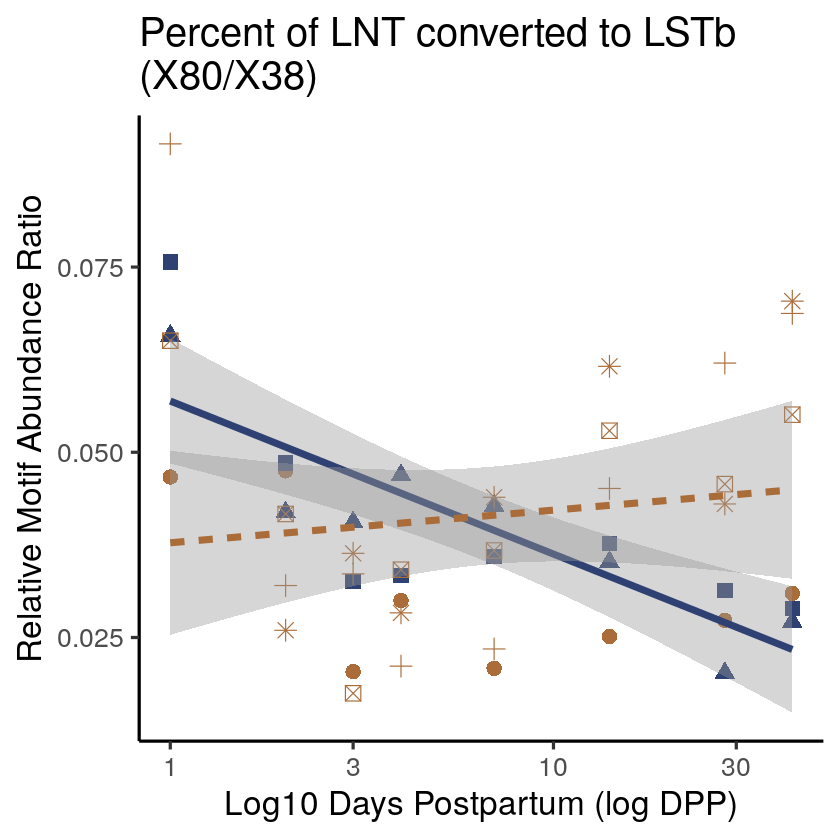

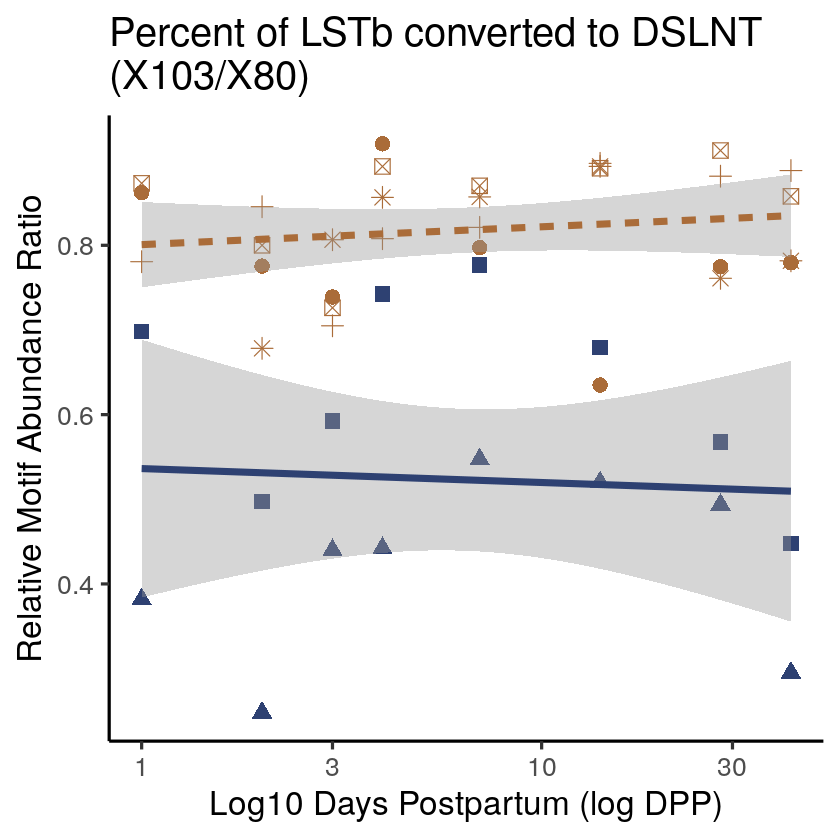

In [554]:

#g = grid.arrange(grobs=list(
    ggplot(data[[1]],aes(x=DPP,y=X80/X38,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(Secretor)))+
        geom_point(size=4,show.legend=F)+stat_smooth(method='lm',size=2,se=TRUE,show.legend=F)+
        theme_classic(base_size=20)+scale_x_log10()+ylab('Relative Motif Abundance Ratio')+
        ggtitle("Percent of LNT converted to LSTb\n(X80/X38)")+xlab("Log10 Days Postpartum (log DPP)")+
        scale_color_manual(values=c("#2E4172", "#AA6C39"))#,
    ggplot(data[[1]],aes(x=DPP,y=X103/X80,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(Secretor)))+
        geom_point(size=4,show.legend=F)+stat_smooth(method='lm',size=2,se=TRUE,show.legend=F)+
        theme_classic(base_size=20)+scale_x_log10()+ylab('Relative Motif Abundance Ratio')+
        ggtitle("Percent of LSTb converted to DSLNT\n(X103/X80)")+xlab("Log10 Days Postpartum (log DPP)")+
        scale_color_manual(values=c("#2E4172", "#AA6C39"))
#),nrow=2)
#ggsave(g,filename='~/Desktop/fig5.pdf',width=13,height=6)

# Power Analysis

In [577]:
library(gee)

add_models=list()
inter_models=list()

i=0
out_i=lapply( data, function(x){
    i=i+1
    x$Secretor = as.numeric(x$Secretor)
    #	x$Secretor = relevel(factor(ifelse(x$Secretor,'secretor','nonsecretor')),ref='nonsecretor')
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        #try(mod<-gee(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
        try(mod<-gee(as.formula(paste('scale(log(',motif,'+.001))~ log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        #try(mod<-gee(as.formula(paste('Secretor~scale(',motif,')+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
    mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
    colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
    mods$type = 'additive'
    mods$robustPr = 2*pnorm(-abs(mods$robustZ))
    mods1=mods[mods$response%in%vars & mods$vars!='Intercept',]
    
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        #try(mod<-gee(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
        try(mod<-gee(as.formula(paste('scale(log(',motif,'+.001))~ Secretor')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        #try(mod<-gee(as.formula(paste('Secretor~scale(',motif,')+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
    mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
    colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
    mods$type = 'additive'
    mods$robustPr = 2*pnorm(-abs(mods$robustZ))
    mods2=mods[mods$response%in%vars & mods$vars!='Intercept',]
    
    rbind(mods1,mods2)
})
out=do.call(rbind,out_i) #[-(4:5)])
out$data = unlist(lapply(strsplit(rownames(out),'\\.'),function(x) x[1]))

Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.238       0.126 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.1405      0.0742 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.309       0.163 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.951      -0.502 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.1602      0.0844 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.640      -0.338 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     0.0682     -0.0360 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.1311      0.0692 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.262       0.138 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.663      -0.350 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.219       0.115 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.941      -0.497 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.1322      0.0698 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.0681      0.0360 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.375       0.198 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.528      -0.279 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.201       0.106 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
   -0.01675     0.00884 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.965      -0.510 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.620       0.328 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.1681      0.0887 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.133       0.070 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.343       0.181 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.231       0.122 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.925       0.489 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.270       0.143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.750       0.396 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.506       0.267 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.919       0.485 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.304      -0.160 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       1.20       -1.82 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.12        1.70 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       1.12       -1.70 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.221      -0.335 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.190       0.287 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.156       0.236 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.918      -1.392 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.35        2.05 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       1.11       -1.68 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.213       0.323 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.861      -1.305 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.412      -0.624 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.458       0.695 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.36        2.06 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       1.07       -1.62 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.726      -1.101 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       1.08       -1.64 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.802      -1.216 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.356      -0.540 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.813      -1.233 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.913      -1.384 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.19        1.80 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.492       0.746 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.263      -0.399 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.602      -0.913 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       0.84       -1.27 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.832      -1.261 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.892      -1.353 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.158      -0.239 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.475      -0.719 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     0.0882     -0.0466 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.421      -0.222 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.658      -0.347 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.891      -0.471 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
   -0.01803     0.00952 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.281      -0.148 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.383      -0.202 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.486      -0.257 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.618      -0.326 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      1.074      -0.567 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.217      -0.114 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.983      -0.519 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.359       0.189 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     0.1793     -0.0947 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.615      -0.325 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.484       0.255 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.25        1.90 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.170      -0.257 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.485       0.735 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.781       1.184 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.290      -0.439 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.27        1.92 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       0.84       -1.27 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.709       1.075 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.673      -1.020 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.475       0.721 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.909       1.378 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.623       0.945 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.183      -0.278 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
    -0.0350      0.0531 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.226       0.343 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.464       0.703 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.0681      0.0360 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.337      -0.178 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     0.0687     -0.0363 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.663      -0.350 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.547       0.289 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.0353      0.0186 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.1006      0.0532 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.515      -0.272 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     0.0252     -0.0133 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.962      -0.508 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.343       0.181 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.897      -0.474 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.750       0.396 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.506       0.267 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.304      -0.160 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.919       0.485 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.36        2.06 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.623      -0.945 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.484      -0.734 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.213       0.323 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.976      -1.480 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.28        1.94 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       1.20       -1.83 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.305       0.463 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       1.22       -1.84 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.263      -0.398 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.492       0.746 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
    -0.0672      0.1019 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.832      -1.261 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.892      -1.353 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.475      -0.719 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.158      -0.239 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”

In [578]:
#### power analysis


### check normality
x=data$glycan_percent
p1=unlist(apply( x[colnames(x)[colnames(x)%in%vars]],2,function(y){
    out=NULL;
    try(out<-shapiro.test(scale(log(y+.001)))$p.value);
    out} ))
x=data$smallest_motif_abundance_dropped_more
p2=unlist(apply( x[colnames(x)[colnames(x)%in%vars]],2,function(y){
    out=NULL;
    try(out<-shapiro.test(scale(log(y+.001)))$p.value);
    out} ))

thresh=.1
pn = c(names(p1)[p.adjust(p1,'fdr')>thresh],names(p2)[p.adjust(p2,'fdr')>thresh])
print(pn)

x1=data$smallest_motif_abundance_dropped_more
x2=data$glycan_percent
vars1 = colnames(x1)[colnames(x1)%in%pn]
vars2 = colnames(x2)[colnames(x2)%in%pn]


#par(mfrow = c(1,3))

##### marginal r^2
mr2<-list(motifs=sapply(out_models$smallest_motif_abundance_dropped_more[vars1],function(mod){
        y = mod$y; y_bar=mean(y); y_hat=mod$fitted.values
        mr2=1-sum((y-y_hat)^2)/sum((y-y_bar)^2)
        mr2
    }),
    glycans=sapply(out_models$glycan_percent[vars2],function(mod){
        y = mod$y; y_bar=mean(y); y_hat=mod$fitted.values
        mr2=1-sum((y-y_hat)^2)/sum((y-y_bar)^2)
        mr2
    }))

### cohen's d

chnD<-list(
    motifs=sapply(vars1[vars1%in%pn],function(yn){
    y=x1[,yn]
    cohen.d(y,factor(x$Secretor), pooled=TRUE, paired=FALSE, na.rm=T, 
        hedges.correction = FALSE, conf.level = 0.95, noncentral = FALSE)$estimate
    }),
    glycans=sapply(vars2[vars2%in%pn],function(yn){
        y=x2[,yn]
        cohen.d(y,factor(x$Secretor), pooled=TRUE, paired=FALSE, na.rm=T, 
            hedges.correction = FALSE, conf.level = 0.95, noncentral = FALSE)$estimate
    }))



###### coeffiecients and noise

keep = out$type=='additive' & out$data%in%keep_data & 
    out$response%in%pn & #!grepl('DPP',rownames(out)) &
    out$robustPr<0.1


 [1] "X3FL"    "LNnT"    "LNFPIII" "LSTc"    "DSLNT"   "FLNH"    "DFLNH"  
 [8] "FDSLNH"  "DSLNH"   "X4"      "X10"     "X26"     "X61"     "X75"    
[15] "X80"     "X103"    "X121"    "X129"    "X137"    "X138"    "X143"   


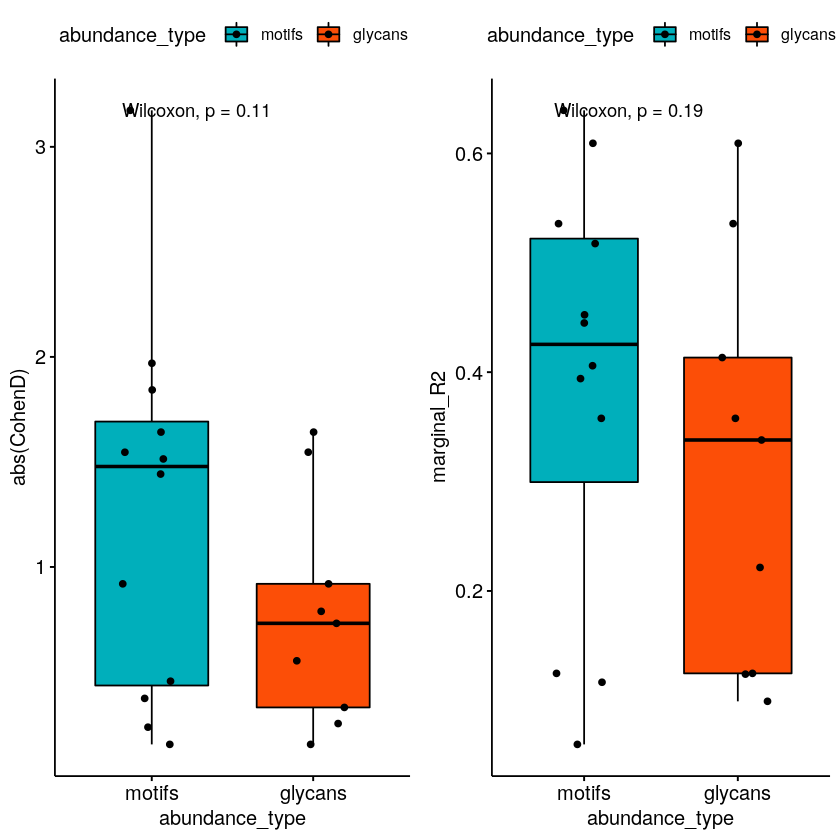

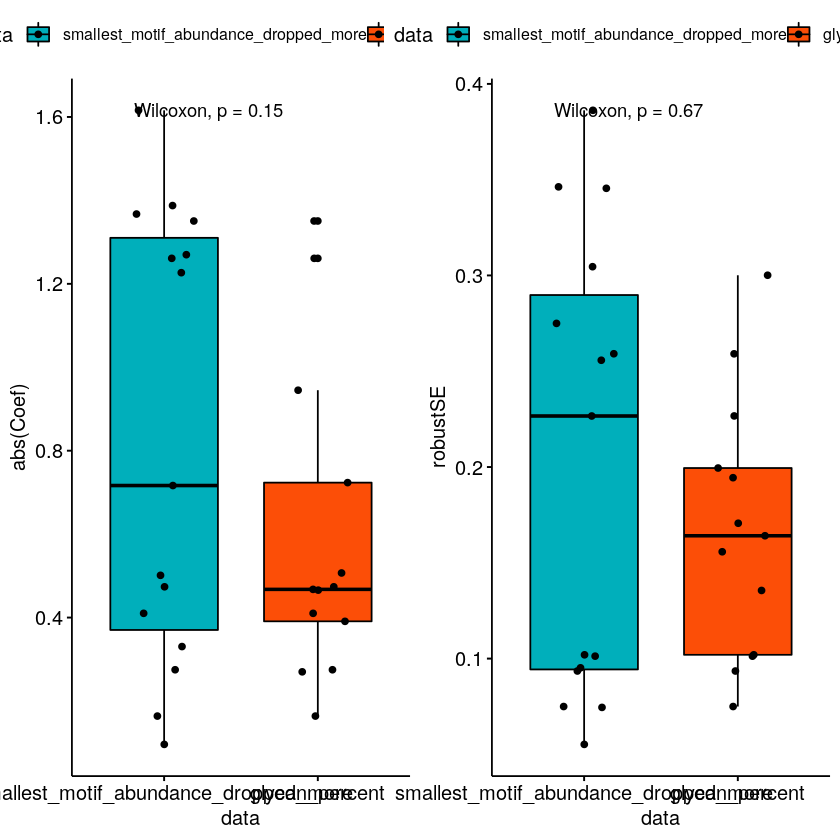

In [579]:
tmp=melt(chnD)
colnames(tmp)=c('CohenD','abundance_type')
p1=ggboxplot(tmp, x = "abundance_type", y = "abs(CohenD)",
                fill = "abundance_type", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

tmp=melt(mr2)
colnames(tmp)=c('marginal_R2','abundance_type')
p2=ggboxplot(tmp, x = "abundance_type", y = "marginal_R2",
                fill = "abundance_type", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

p3=ggboxplot(droplevels(out[keep,]),x='data',y='abs(Coef)',
                fill = "data", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

p4=ggboxplot(droplevels(out[keep,]),x='data',y='robustSE',
                fill = "data", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "greater"))


g1<-grid.arrange(grobs=list(p1,p2),nrow=1)
g2<-grid.arrange(grobs=list(p3,p4),nrow=1)
#g = grid.arrange(grobs=list(p1,p2,p3,p4),nrow=1)
#ggsave(grid.arrange(grobs=list(p1,p2,p3,p4),nrow=2),filename = '~/Desktop/poweranyl.pdf',height=10,width=10)

In [489]:
#summary(aov(abs(Coef) ~ data , data=droplevels(out[keep,])))
#summary(aov(Coef ~ data , data=droplevels(out[keep,])))
#summary(aov(robustSE ~ data , data=droplevels(out[keep,])))

# dfmr2 = data.frame(mr2=c(mr2$motifs,mr2$glycans),
#                    type=c(rep('motifs',length(mr2$motifs)),rep('glycans',length(mr2$glycans))))

# #summary(aov(mr2~type, dfmr2))
# t.test(mr2$motifs,mr2$glycans)
# wilcox.test(mr2$motifs,mr2$glycans)

#t.test(abs(mr2$motifs),abs(mr2$glycans),alternative = 'greater')
#wilcox.test(abs(mr2$motifs),abs(mr2$glycans),alternative='greater')

#t.test(abs(chnD$motifs),abs(chnD$glycans),alternative = 'greater')
#wilcox.test(abs(chnD$motifs),abs(chnD$glycans),alternative='greater')

#t.test(abs(hG$motifs),abs(hG$glycans),alternative = 'greater')
#wilcox.test(abs(hG$motifs),abs(hG$glycans),alternative='greater')


## Using the likelihood ratio test to determine if more complex substructures are significantly more predictive of secretor status 

In [63]:
#### load heirachy
r = read.csv('motifAnyl/motif_heir.12.7.18.Bokan/edges.txt',header=F)
heir = graph_from_edgelist( cbind( as.character(r[,1]) , as.character(r[,2]) ))
#plot(heir, layout=layout_as_tree(heir))

#### data
tmp = data[[1]]

comp=list()
comp_clean=list()
for( e in E(heir)){
    print(ends(heir,e))
    en=as.character(ends(heir,e))
    if(any(! paste0('X',en) %in% colnames(tmp) )){print(paste('skip',paste(en,collapse='_')));next}
    if( !all( apply(tmp[,paste0('X',en)],2,sd) > 1e-4 ) | all( tmp[[paste0('X',en[1])]] == tmp[[paste0('X',en[2])]] ) ){
        print(paste('skip',paste(en,collapse='_')));
        next
    }
    # run models
    f1 = as.formula(paste('Secretor ~',paste0('X',en[1])))
    f2 = as.formula(paste('Secretor ~',paste(paste0('X',en),collapse='+')  ))
    m1 = geeglm( f1, id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    m2 = geeglm( f2 , id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    aov = anova(m1,m2,test='LRT')
    out = data.frame( rbind(coef(summary(m1)) , coef(summary(m2))) )
    out$model = c(rep('m1',2),rep('m2',3))
    out$iter = paste(en,collapse='_')
    eni = c('Intercept',en)
    out$vars = c(eni[1:2],eni[1:3])
    out$LRT = aov[[3]]
    if(any(abs(out$Estimate)>15)){next}
    comp[[paste(en,collapse='_')]] = list(m1,m2,aov)
    comp_clean[[paste(en,collapse='_')]] = out
}
head(do.call(rbind,comp_clean))



     [,1] [,2]
[1,] "5"  "20"
[1] "skip 5_20"
     [,1] [,2]
[1,] "5"  "21"
[1] "skip 5_21"
     [,1] [,2]
[1,] "5"  "26"
[1] "skip 5_26"
     [,1] [,2]
[1,] "5"  "29"
[1] "skip 5_29"
     [,1] [,2]
[1,] "5"  "35"
[1] "skip 5_35"
     [,1] [,2]
[1,] "20" "37"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "38"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "40"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "41"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "43"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "51"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "53"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "26" "43"
     [,1] [,2]
[1,] "29" "45"
[1] "skip 29_45"
     [,1] [,2]
[1,] "29" "46"
     [,1] [,2]
[1,] "29" "51"
[1] "skip 29_51"
     [,1] [,2]
[1,] "37" "61"
[1] "skip 37_61"
     [,1] [,2]
[1,] "37" "64"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "61"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "65"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "79"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "80"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "85"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "86"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "40" "62"
     [,1] [,2]
[1,] "40" "63"
     [,1] [,2]
[1,] "40" "73"
     [,1] [,2]
[1,] "41" "62"
[1] "skip 41_62"
     [,1] [,2]
[1,] "41" "74"
     [,1] [,2]
[1,] "43" "64"
[1] "skip 43_64"
     [,1] [,2]
[1,] "43" "65"
[1] "skip 43_65"
     [,1] [,2]
[1,] "45" "66"
     [,1] [,2]
[1,] "45" "75"
[1] "skip 45_75"
     [,1] [,2]
[1,] "45" "88"
     [,1] [,2]
[1,] "46" "66"
[1] "skip 46_66"
     [,1] [,2]
[1,] "46" "76"
[1] "skip 46_76"
     [,1] [,2]
[1,] "51" "73"
     [,1] [,2]
[1,] "51" "74"
     [,1] [,2]
[1,] "51" "75"
[1] "skip 51_75"
     [,1] [,2]
[1,] "51" "76"
     [,1] [,2]
[1,] "51" "81"
     [,1] [,2]
[1,] "51" "85"
     [,1] [,2]
[1,] "53" "80"
[1] "skip 53_80"
     [,1] [,2]
[1,] "53" "81"
     [,1] [,2]
[1,] "61" "92"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "62" "97"
     [,1] [,2] 
[1,] "62" "113"
     [,1] [,2] 
[1,] "63" "113"
     [,1] [,2] 
[1,] "63" "116"
     [,1] [,2]
[1,] "64" "92"
[1] "skip 64_92"
     [,1] [,2]
[1,] "65" "92"
[1] "skip 65_92"
     [,1] [,2] 
[1,] "66" "102"
[1] "skip 66_102"
     [,1] [,2]
[1,] "73" "97"
[1] "skip 73_97"
     [,1] [,2]
[1,] "73" "98"
[1] "skip 73_98"
     [,1] [,2] 
[1,] "73" "100"
     [,1] [,2] 
[1,] "73" "116"
     [,1] [,2]
[1,] "74" "97"
[1] "skip 74_97"
     [,1] [,2]
[1,] "74" "99"
[1] "skip 74_99"
     [,1] [,2] 
[1,] "74" "101"
     [,1] [,2]
[1,] "75" "98"
     [,1] [,2]
[1,] "75" "99"
     [,1] [,2] 
[1,] "75" "102"
     [,1] [,2] 
[1,] "75" "104"
     [,1] [,2] 
[1,] "75" "110"
     [,1] [,2] 
[1,] "75" "117"
     [,1] [,2] 
[1,] "76" "100"
[1] "skip 76_100"
     [,1] [,2] 
[1,] "76" "101"
[1] "skip 76_101"
     [,1] [,2] 
[1,] "76" "102"
[1] "skip 76_102"
     [,1] [,2] 
[1,] "79" "103"
[1] "skip 79_103"
     [,1] [,2] 
[1,] "79" "108"
     [,1] [,2] 
[1,] "80" 

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "80" "109"
     [,1] [,2] 
[1,] "81" "104"
[1] "skip 81_104"
     [,1] [,2] 
[1,] "81" "109"
[1] "skip 81_109"
     [,1] [,2] 
[1,] "85" "108"
     [,1] [,2] 
[1,] "85" "109"
     [,1] [,2] 
[1,] "85" "110"
[1] "skip 85_110"
     [,1] [,2] 
[1,] "85" "112"
     [,1] [,2] 
[1,] "86" "112"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "88" "117"
[1] "skip 88_117"
     [,1] [,2] 
[1,] "97" "121"
[1] "skip 97_121"
     [,1] [,2] 
[1,] "97" "122"
     [,1] [,2] 
[1,] "97" "130"
     [,1] [,2] 
[1,] "98" "121"
[1] "skip 98_121"
     [,1] [,2] 
[1,] "98" "123"
     [,1] [,2] 
[1,] "98" "135"
     [,1] [,2] 
[1,] "98" "136"
     [,1] [,2] 
[1,] "99" "121"
[1] "skip 99_121"
     [,1] [,2] 
[1,] "99" "124"
     [,1] [,2] 
[1,] "99" "131"
     [,1]  [,2] 
[1,] "100" "122"
[1] "skip 100_122"
     [,1]  [,2] 
[1,] "100" "123"
[1] "skip 100_123"
     [,1]  [,2] 
[1,] "101" "122"
[1] "skip 101_122"
     [,1]  [,2] 
[1,] "101" "124"
[1] "skip 101_124"
     [,1]  [,2] 
[1,] "102" "123"
[1] "skip 102_123"
     [,1]  [,2] 
[1,] "102" "124"
[1] "skip 102_124"
     [,1]  [,2] 
[1,] "103" "126"
     [,1]  [,2] 
[1,] "104" "128"
[1] "skip 104_128"
     [,1]  [,2] 
[1,] "108" "126"
[1] "skip 108_126"
     [,1]  [,2] 
[1,] "108" "127"
[1] "skip 108_127"
     [,1]  [,2] 
[1,] "109" "126"
[1] "skip 109_126"
     [,1]  [

,Estimate,Std.err,Wald,Pr...W..,model,iter,vars,LRT
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
26_43.(Intercept),0.69494924,0.86693136,0.6425941,0.4227730,m1,26_43,Intercept,0.1158514
26_43.X26,-0.01889897,0.02903672,0.4236243,0.5151341,m1,26_43,26,0.1158514
26_43.(Intercept)1,0.69710437,0.86682828,0.6467396,0.4212808,m2,26_43,Intercept,0.1158514
26_43.X261,0.09174131,0.06288704,2.1281759,0.1446128,m2,26_43,26,0.1158514
26_43.X43,-0.16576369,0.10543322,2.4718600,0.1159007,m2,26_43,43,0.1158514
53_81.(Intercept),0.68414491,0.86525408,0.6251855,0.4291268,m1,53_81,Intercept,0.9929525


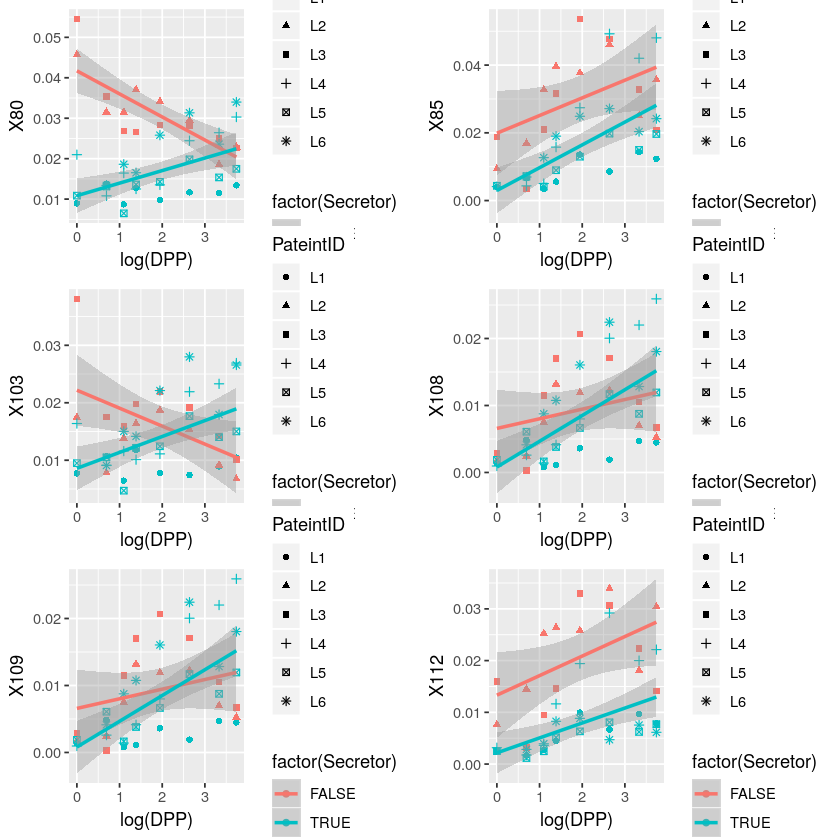

In [61]:
g=grid.arrange(grobs=list(
	ggplot(data[[1]],aes(x=log(DPP),y=X80,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X85,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X103,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X108,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X109,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X112,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm')
	))

In [73]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] geepack_1.2-1       gee_4.13-19         heatmap.plus_1.3   
 [4] lme4_1.1-21         openxlsx_4.1.0.1    reshape2_1.4.3     
 [7] metap_1.1           GGally_1.4.0        ggrepel_0.8.1      
[10] colorRamps_2.3      stringr_1.4.0       MASS_7.3-51.4 